# Optimizing QAOA

Consider a quantum alternating operator ansatz(QAOA) consisting of two types of driving Hamiltonian. We consider the following form of control sequence:
$$
U(\{\alpha_i, \beta_i| i=1,\ldots n \}) = e^{i\beta_n h^{(2)}} e^{i\alpha_n h^{(1)}}\cdots e^{i\beta_1 h^{(2)}}e^{i\alpha_1 h^{(1)}}.
$$
Suppose we change only one of the parameters. We are interested in the smoothnes of the energy landscape. Suppose that the energy landscape can be approximated well by a few Fourier coefficients. That is, there exists a rank-$r$ approximation of the function.
$$
\inf_{\{a_i \}} |E(\alpha_i) - \sum_{i=1} a_{j_i} \cos \alpha_i| \leq \epsilon.
$$
Let the approximation be $\tilde{E}(\alpha_i)$. Then the global minimum of the approximation is by definition at most $\epsilon$ apart from the global minimum of the original function. 

## Comparison 

There are two quantities to consider. The first is the sample complexity: how many samples do we need to find the global minimum up to an error $\epsilon$? The second is the total computation time. What is the actual amount of time to compute the global minimum?

In this note, we compare three different methods, under two assumptions.

### Assumptions

In order to compare different optimization methods, we will need to make a few nontrivial assumptions.

#### Periodicity
1. Periodic case: In certain cases, we are promised that $E(\alpha_i)= E(\alpha_i + \pi)$. In this case, we are only interested in $\alpha_i \in [0,\pi]$.

2. Aperiodic case: The periodicity assumption will be invalid in general. In this case, we will need to introduce a cutoff for the maximum value of $\alpha_i$. In the experiment, it will make sense to use $\alpha_i \in [0, 1/\tau_d]$, where $\tau_d$ is the coherence time.

#### Continuity
We will assume that there is a finite Lipschitz constant L:
$$
|E(x) - E(y)| \leq L|x-y|.
$$

#### Convexity
Of course $E(\alpha_i)$ will not be convex in general, but we can still assume that it is and then compare different methods, at least for comparing gradient-based methods.

#### Sparse Fourier coefficients
Let us assume that $E(\alpha_i)$ has only $k$ Fourier coefficients.

### Methods
1. Brute-force search: Divide up the interval

2. Gradient descent: Estimate the gradient at a given point, and then perform gradient descent. Note that there will be a stochastic noise.

3. Fitting-based method: Measure energy for a few values of $\alpha_i$ and fit to a function with sparse Fourier coefficient.

### Sample Complexity

Gradient descent algorithm, applied to a convex and differentiable function with a finite Lipschitz constant, converges in time $1/\epsilon$.

1. If we apply the gradient descent algorithm, we probably need to estimate the gradient with a statistical noise of at least $\epsilon$. So the total sample complexity would scale as $O(\frac{1}{\epsilon^3})$. Actually, because one must use $O(1/\epsilon)$ iterations, a sum of noise over these steps may fluctuate with a prefactor $O(\sqrt{1/\epsilon})$. In order to suppress this contribution up to a $O(\epsilon)$ error, the statistical accuracy for estimating gradient must be $O(\epsilon^{3/2})$. In that case, the total sample complexity would scale as $O(\frac{1}{\epsilon^4})$.


2. Suppose we have a promise that there is a rank-$r$ approximation. Then we have a sample complexity of probably $O(\frac{r}{\epsilon^2})$.

### Time Estimate

1. If we estimate the gradient directly, we have $T_{\text{total}} = O(\frac{\tau_q}{\epsilon^3})$, where $\tau_q$ is the time for one-shot measurement. But according to a more conservative analysis given above, the total might scale as $T_{\text{total}} = O(\frac{\tau_q}{\epsilon^4})$.

2. If we fit the function, then we have $T_{\text{total}} = O(\frac{\tau_q r}{\epsilon^2}) + O(\frac{r\tau_c}{\epsilon})$, where $\tau_c$ is the time for elementary arithmetic operations involving trigonometric functions. Assuming that $\tau_c \leq \tau_q$, the second term becomes negligible. So we see that there is an advantage in fitting the function to some fixed form. 


In [6]:
import numpy as np
import scipy.linalg as la
from scipy import sparse
import matplotlib.pyplot as plt

# Experiment

As a test example, suppose we are trying to optimize the following objective function.
$$
E(\theta) = \langle \psi| (e^{-i\theta Z})^{\otimes k}O(e^{i\theta Z})^{\otimes k}|\psi \rangle
$$
for a random observable $O$ and a arandom state $| \psi\rangle$. Here $|\psi\rangle$ is chosen randomly uniformly over the Hilbert space and $O= U(Z\otimes I \otimes \cdots \otimes I)U^{\dagger}$.

In [2]:
# Number of qubits
n= 8
# Define Z
Z= np.array([[1,0],[0,-1]])

In [3]:
# Random Unitary 1
X = (np.random.randn(2**n, 2**n) + 1j * np.random.randn(2**n, 2**n))/np.sqrt(2)
Q,R = np.linalg.qr(X)
R = np.diag(np.diag(R)/abs(np.diag(R)))
U1 = Q @ R

# Random Unitary 2
X = (np.random.randn(2**n, 2**n) + 1j * np.random.randn(2**n, 2**n))/np.sqrt(2)
Q,R = np.linalg.qr(X)
R = np.diag(np.diag(R)/abs(np.diag(R)))
U2 = Q @ R

In [4]:
itt = 50


# Create an observable
I = np.array([[1,0],[0,1]])
ob = Z
for k in range(n-1):
    ob = sparse.kron(ob, I)
    
    
# Initialize the record
Record = []

for i in range(itt):
    # Create a state
    psi = np.zeros(2**n)
    psi[0] = 1
    psi = U1 @ psi
    # Create a single unitary
    theta = np.pi * i / itt
    ctrl_loc = la.expm(1j * theta * Z)
    
    # Create a control unitary
    ctrl = 1
    for j in range(n):
        ctrl = sparse.kron(ctrl, ctrl_loc)
        
    # Apply the control
    psi = ctrl @ psi
    
    # Measure
    Record.append(np.real(psi.conj().T @ U2 @ ob @ U2.conj().T @ psi))
    

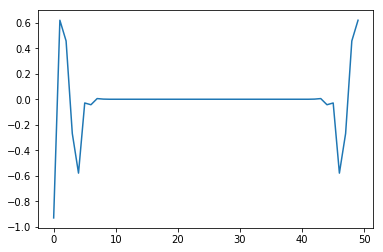

array([-9.29843361e-01,  6.19007184e-01,  4.56800267e-01, -2.68559028e-01,
       -5.78918075e-01, -2.92844067e-02, -4.30651519e-02,  5.25771058e-03,
        1.06721619e-03,  3.88578059e-16, -1.66533454e-16, -4.02807717e-17,
       -1.06360233e-16, -3.03576608e-18, -3.12250226e-16,  6.07153217e-17,
       -3.88578059e-16,  1.66533454e-16, -2.77555756e-16, -5.55111512e-16,
        1.66533454e-16,  2.05175961e-16,  3.32633227e-16,  1.18828558e-16,
        8.37871439e-16,  3.69929781e-16,  8.25728375e-16,  7.28583860e-17,
        4.30211422e-16,  2.77555756e-16,  1.66533454e-16, -3.71709414e-16,
       -2.07733136e-16,  4.77048956e-17, -6.15826834e-16, -1.86482774e-17,
        4.85722573e-17,  1.42247325e-16, -2.35922393e-16, -2.77555756e-16,
       -1.66533454e-16,  2.06814225e-16,  1.06721619e-03,  5.25771058e-03,
       -4.30651519e-02, -2.92844067e-02, -5.78918075e-01, -2.68559028e-01,
        4.56800267e-01,  6.19007184e-01])

In [8]:
myfft=np.real(np.fft.fft(Record))
plt.plot(myfft)
plt.show()
myfft

One can see that the number of Fourier coefficient is small, but this was to some extent expected. The number of $e^{i\theta Z}$ term is at most $16$, so the sparsity may be coming from the fact that $16$ is a small number. In order to test how sparse the Fourier coefficients are, we can imagine identifying some of the $\alpha_i$s to be equal to each other. 

In [21]:
itt = 50
layers = 5

# Create an observable
I = np.array([[1,0],[0,1]])
ob = Z
for k in range(n-1):
    ob = sparse.kron(ob, I)
    
    
# Initialize the record
Record = []

for i in range(itt):
    # Create a state
    psi = np.zeros(2**n)
    psi[0] = 1
    psi = U1 @ psi
    # Create a single unitary
    theta = np.pi * i / itt
    ctrl_loc = la.expm(1j * theta * Z)
    
    # Create a control unitary
    ctrl = 1
    for j in range(n):
        ctrl = sparse.kron(ctrl, ctrl_loc)
        
    # Create an ansatz
    psi_ansatz = psi
    for j in range(layers):
        psi_ansatz = ctrl @ psi_ansatz
        psi_ansatz = U2.conj().T @ psi_ansatz
    
    # Measure
    Record.append(np.real(psi_ansatz.conj().T @ ob @ psi_ansatz))

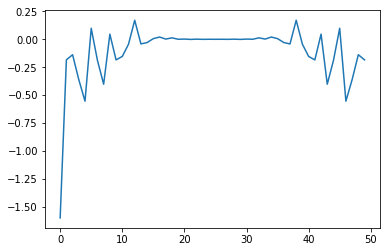

array([-1.60102223e+00, -1.84499314e-01, -1.38228788e-01, -3.62218166e-01,
       -5.54634781e-01,  9.87741897e-02, -1.88989235e-01, -4.02660521e-01,
        4.59875728e-02, -1.84802161e-01, -1.53765111e-01, -4.45907739e-02,
        1.70596506e-01, -4.17054583e-02, -2.91117140e-02,  5.70007228e-03,
        2.01638132e-02,  1.74974586e-03,  1.29738452e-02,  1.41653413e-04,
        1.90172521e-03, -1.08795911e-03,  1.05325843e-03, -6.10770076e-04,
        2.70675590e-04, -2.41806463e-04,  2.70675590e-04, -6.10770076e-04,
        1.05325843e-03, -1.08795911e-03,  1.90172521e-03,  1.41653413e-04,
        1.29738452e-02,  1.74974586e-03,  2.01638132e-02,  5.70007228e-03,
       -2.91117140e-02, -4.17054583e-02,  1.70596506e-01, -4.45907739e-02,
       -1.53765111e-01, -1.84802161e-01,  4.59875728e-02, -4.02660521e-01,
       -1.88989235e-01,  9.87741897e-02, -5.54634781e-01, -3.62218166e-01,
       -1.38228788e-01, -1.84499314e-01])

In [23]:
myfft=np.real(np.fft.fft(Record))
plt.plot(myfft)
plt.show()
myfft